In [1]:
!pip install -r requirement.txt

In [36]:
import numpy as np
import geatpy as ea
import pandas as pd
import random
from datetime import datetime
import parser
print(ea.__version__)

debug = 1 # debug mode

2.7.0


### READ DATA
TODO: read data from GP

In [37]:
rawData = pd.read_excel(io='./FCI ANZ (2022-07-08) (NBV as at 30 Jun 2022)_v2.xlsx', sheet_name='Raw (portfolio)', engine='openpyxl')

In [38]:
# randomly choose 1000 samples
# TODO: select all data
n = 10000
rawData = rawData.iloc[:30000, :61]

In [41]:
data = rawData.sample(n)
print(data.shape)
data.sample(3)

(10000, 61)


,Business Unit (Contract),Business Unit Am,Unit Id Fz,Cost,Po Num Fz,Mfr Dt Fz,Asset Id,Pool Fz,Product,Birth Unit Id Fz,...,Correct CEU,NP year,NBV check,age at drawdown X CEU,RML at drawdown X CEU,category,string,filter 2017 contracts,contract units,filter no. of units
18391,FZOPS,DF3RM,FFAU4053589,6000.0,CSIH-FL-2115,4/12/2021,1708255.0,DFC3,D4H,FFAU4053589,...,1.7,2021 NP,Reasonable,3.350164,10.637808,from ANZ portfolio,LT-MSC-48D4H,NaN,6997.0,1.0
13525,FZOPS,DF3RM,FFAU4071427,6007.0,SMSL-FL-2105,4/28/2021,1722539.0,DFC3,D4H,FFAU4071427,...,1.7,2021 NP,Reasonable,3.265164,10.637808,from ANZ portfolio,LT-MSC-48D4H,NaN,6997.0,1.0
16905,FZOPS,DF3RM,FFAU3890791,6000.0,CSIH-FL-2114,5/9/2021,1721126.0,DFC3,D4H,FFAU3890791,...,1.7,2021 NP,Reasonable,3.214164,10.637808,from ANZ portfolio,LT-MSC-48D4H,NaN,6997.0,1.0


### DATA PREPARATION

In [43]:
# TODO: add more columns later
input_data = \
    data.loc[:, ['Cost', 'Mfr Dt Fz', 'Product', 'Contract Cust Id', 'Contract Dt', 'Contract Expiration Dt', \
                 'Nbv', 'Billing Status Fz', 'Fleet Year Fz', 'Age x CEU', 'Contract Lease Type']]
input_data.head(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Fleet Year Fz,Age x CEU,Contract Lease Type
3463,3682.0,2/28/2018,D4H,MSC,2018-03-01,2032-07-31,2917.311,ON,4.33,7.361,LT
1240,3832.0,12/18/2017,D4H,HAPAG,2017-11-01,2030-01-31,2981.838,ON,4.53,7.701,LF
3623,3682.0,2/28/2018,D4H,MSC,2018-03-01,2032-07-31,2917.311,ON,4.33,7.361,LT


#### Find standard equipment

Assign to `StandardEqip`

In [35]:
# select standard equipment
standardEquipment = ['D4H', 'D20', 'D40']
def SelectStandardEquip(Product):
    if Product in standardEquipment:
        Product = 1
    else:
        Product = 0
    return Product

input_data['Product'] = input_data.apply(lambda x: SelectStandardEquip(x['Product']), axis=1)
input_data.head(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
16457,6000.0,5/9/2021,0,MSC,2021-04-01,2029-06-30,5612.35,1,1,1,1.39,6.76
18318,6000.0,4/12/2021,0,MSC,2021-04-01,2029-06-30,5612.35,1,1,1,1.46,6.76
29722,2182.0,1/2/2018,0,HAPAG,2017-11-01,2030-01-31,1784.49,1,0,1,4.74,7.35


#### Find Top 1 and Top 3 Lessees

Assign new column `Top1Lessee` and `Top3Lessees`

In [8]:
# select the Top1 lessee
input_data.groupby('Contract Cust Id').count().sort_values('Cost', ascending=False)

,Cost,Mfr Dt Fz,Product,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz
Contract Cust Id,,,,,,,
MSC,4172,4172,4172,4172,4172,4172,4172
ONE,3695,3695,3695,3695,3695,3695,3695
HAPAG,1921,1921,1921,1921,1921,1921,1921
TCLC,74,74,74,74,74,74,74
COSMR,54,54,54,54,54,54,54
CMA,48,48,48,48,48,48,48
PANOCEAN,36,36,36,36,36,36,36


In [9]:
# top1 and top3 lessees 
Top1Lessee = 'MSC'
Top3Lessees = ['MSC', 'ONE', 'HAPAG']

In [10]:
def SelectTop1(custID):
    if custID == Top1Lessee:
        custID = 1
    else:
        custID = 0
    return custID

def SelectTop3(custID):
    if custID in Top3Lessees:
        custID = 1
    else:
        custID = 0
    return custID

input_data['Top1Lessee'] = input_data.apply(lambda x: SelectTop1(x['Contract Cust Id']), axis=1)
input_data['Top3Lessees'] = input_data.apply(lambda x: SelectTop3(x['Contract Cust Id']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees
22081,2267.0,3/22/2018,1,ONE,2018-02-01,2026-10-14,1888.001,ON,0,1
26116,2262.0,3/21/2018,1,ONE,2018-02-01,2026-10-14,1884.210,ON,0,1
360,3832.0,12/18/2017,1,HAPAG,2017-11-01,2030-01-31,2981.836,ON,0,1


#### Calcualte manufacture age
Assign new column `MfrAge`

In [11]:
# TODO: consider timezone, consider time_now in the future
time_now = datetime.now()
# calculate manufacture age
date_format = '%m/%d/%Y'
# return in years, round to 2 decimal
def CalculateManufacutreAge(date):
    diff = time_now.date() - datetime.strptime(date, date_format).date()
    return round(diff.days / 365, 2)

input_data['MfrAge'] = input_data.apply(lambda x: CalculateManufacutreAge(x['Mfr Dt Fz']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge
15114,6000.0,4/8/2021,1,MSC,2021-04-01,2029-06-30,5612.350,ON,1,1,1.47
2397,3832.0,12/18/2017,1,HAPAG,2017-11-01,2030-01-31,2981.797,ON,0,1,4.78
12877,4420.0,3/3/2021,1,ONE,2020-11-16,2029-05-15,4117.430,ON,0,1,1.57


#### Calculate unexpired year 
Assign new column `ExpYear`

In [12]:
# TODO: consider timezone, consider time_now in the future
# TODO: 'Contract Expiration Dt' is in Timestamp, the data type may change
time_now = datetime.now()
# calculate manufacture age
date_format = '%Y-%m-%d'
# return in years, round to 2 decimal
def CalculateExpYear(date):
    diff = pd.to_datetime(date,format="%Y%m%d").date() - time_now.date()
    return round(diff.days / 365, 2)

input_data['ExpYear'] = input_data.apply(lambda x: CalculateExpYear(x['Contract Expiration Dt']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
19510,3849.0,4/6/2018,1,ONE,2018-02-01,2026-10-14,3123.450,ON,0,1,4.48,4.05
8345,3702.0,6/11/2018,1,MSC,2018-03-01,2032-07-31,2967.910,ON,1,1,4.30,9.85
2213,3832.0,12/18/2017,1,HAPAG,2017-11-01,2030-01-31,2981.798,ON,0,1,4.78,7.35


Select billing status

In [13]:
def SelectBilling(status):
    if status == 'ON':
        status = 1
    else:
        status = 0
    return status

input_data['Billing Status Fz'] = input_data.apply(lambda x: SelectBilling(x['Billing Status Fz']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
27434,3682.0,1/1/2018,1,HAPAG,2017-11-01,2030-01-31,2869.540,1,0,1,4.74,7.35
7377,3702.0,6/11/2018,1,MSC,2018-03-01,2032-07-31,2983.220,1,1,1,4.30,9.85
4435,3682.0,2/28/2018,1,MSC,2018-03-01,2032-07-31,2933.004,1,1,1,4.58,9.85


Save data

In [14]:
input_data.to_csv('prepared_data.csv')

In [15]:
prepared_data = pd.read_csv('./prepared_data.csv')
prepared_data.head(3)

,Unnamed: 0,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
0,16457,6000.0,5/9/2021,1,MSC,2021-04-01,2029-06-30,5612.35,1,1,1,1.39,6.76
1,18318,6000.0,4/12/2021,1,MSC,2021-04-01,2029-06-30,5612.35,1,1,1,1.46,6.76
2,29722,2182.0,1/2/2018,1,HAPAG,2017-11-01,2030-01-31,1784.49,1,0,1,4.74,7.35


### Model Part

#### Input

Convert pandas to numpy array

TODO: set input, may consider alt way.

In [16]:
prepared_data.describe()

,Unnamed: 0,Cost,Product,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
count,10000.000000,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000
mean,15004.415500,4000.476758,1.0,3459.791101,1.0,0.417200,0.978800,3.494026,6.685490
std,8637.816236,1238.455978,0.0,1291.022238,0.0,0.493121,0.144058,1.498881,2.021827
min,0.000000,2182.000000,1.0,1784.484000,1.0,0.000000,0.000000,1.360000,1.010000
25%,7581.750000,3682.000000,1.0,2869.540000,1.0,0.000000,1.000000,1.520000,4.050000
50%,14970.500000,3832.000000,1.0,2981.836000,1.0,0.000000,1.000000,4.520000,6.760000
75%,22562.500000,4420.000000,1.0,4155.250000,1.0,1.000000,1.000000,4.740000,7.350000
max,29999.000000,7081.000000,1.0,6626.060000,1.0,1.000000,1.000000,4.790000,9.850000


In [20]:
cost = prepared_data['Cost'].to_numpy().reshape(n, 1)
nbv = prepared_data['Nbv'].to_numpy().reshape(n, 1)
product = prepared_data['Product'].to_numpy()
mfrAge = prepared_data['MfrAge'].to_numpy().reshape(n, 1)
lesseStatus = prepared_data['Billing Status Fz'].to_numpy()
expYear = prepared_data['ExpYear'].to_numpy().reshape(n, 1)
top1 = prepared_data['Top1Lessee'].to_numpy()
top3 = prepared_data['Top3Lessees'].to_numpy()

if debug:
    print('nbv shape: ', nbv.shape)
    print('product shape: ', product.shape)
    print('mfrAge shape: ', mfrAge.shape)
    print('lesseStatus shape: ', lesseStatus.shape)
    print('expYear shape: ', expYear.shape)


nbv shape:  (10000, 1)
product shape:  (10000,)
mfrAge shape:  (10000, 1)
lesseStatus shape:  (10000,)
expYear shape:  (10000, 1)


#### Constraints

`x`: np.array, size=num_of_container. `x[i]=1` stands for $i^{th}$ container is selected; `x[i]=0` stands for $i^{th}$ container is not selected.

1. minTotalNbv <= Total NBV <= maxTotalNbv
    
    1. Total NBV >= minTotalNbv
    
    2. Total NBV <= maxTotalNbv
    
2. minTotalCost <= Total Cost <= maxTotalCost

    1. Total Cost >= minTotalCost
    
    2. Total Cost <= maxTotalCost
    
3. Container Age

    1. fleetAge1
    
    2. fleetAge2
    
    3. fleetAge3
    
4. Status: TODO

5. Weighted Age

    1. weightedAge1
    
    2. weightedAge2
    
    3. weightedAge3

6. Product

    1. product1
    
    2. product2
    
    3. product3
    
7. Lessee

    1. lessee1
    
    2. lessee2
    
    3. lessee3
    
8. Contract Type

    1. contractType1
    
    2. contractType2
    
    3. contractType3

    
> 1. NBV of standard equip >= 80%: `-((Vars * product @ nbv) / (Vars @ nbv) - 0.8)`
> 
> 2. Avg age of equip <= 3.75: `sum(x*Fleet Year Fz) / sum(x) <= 3.75`
> 
> 3. Avg age of Manufacturing < 7: `(Vars @ mfrAge) / Vars.sum(axis=1, keepdims=True) - 7`
>
> 4. Equipment port subject to lease >= 90%: TODO
> 
> 5. Avg unexpired term under leases >= 5: `-((Vars * lesseStatus @ expYear) / (Vars * lesseStatus).sum(axis=1, keepdims=True) - 5)`
> 
> 6. Top 1 NBV <= 50%: `(Vars * top1 @ nbv) / (Vars @ nbv) - 0.5`
> 
> 7. Top 3 NBV <= 70%: `(Vars * top3 @ nbv) / (Vars @ nbv) - 0.7`


#### Objective

1. min Cost: `Vars @ cost`

2. max Nbv: `Vars @ nbv`

#### Define Problem
Define objective function and constraint functions

In [32]:
def DEMO():
    class MyProblem(ea.Problem):
        def __init__(self):
            name ='MyProblem'
            M = 1
            maxormins = [1] # -1: max, 1: min
            Dim = n # num of variables
            varTypes = [1] * Dim # integers: 0 or 1
            lb = [0] * Dim # low bound
            ub = [1] * Dim # up bound
            lbin = [1] * Dim # low bound include
            ubin = [1] * Dim # up bound include
            ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb,ub, lbin, ubin)
            
        def aimFunc(self, pop):
            Vars = pop.Phen
            
            # two optimization methods are showed below. now we only care the first one.
            pop.ObjV = Vars @ cost

            pop.CV = np.hstack([
                -((Vars * product @ nbv) / (Vars @ nbv) - 0.8),
                (Vars @ mfrAge) / Vars.sum(axis=1, keepdims=True) - 7,
                -((Vars * lesseStatus @ expYear) / (Vars * lesseStatus).sum(axis=1, keepdims=True) - 5),
#                 (Vars * top1 @ nbv) / (Vars @ nbv) - 0.5,
#                 (Vars * top3 @ nbv) / (Vars @ nbv) - 0.7,
            ])




    problem = MyProblem()
    Encoding ='RI'
    NIND = 100 # init number of population instance
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges,problem.borders)
    population = ea.Population(Encoding, Field, NIND)

    # set parameters
    myAlgorithm = ea.soea_DE_best_1_L_templet(problem, population)
    myAlgorithm.MAXGEN = 10000
    myAlgorithm.mutOper.F = 0.5
    myAlgorithm.recOper.XOVR = 0.7 # probability of chrom crossover
    myAlgorithm.logTras = 1 # record log each logTras generations
    myAlgorithm.trappedValue = 1e-6
    myAlgorithm.maxTrappedCount = 2000

    # TODO: random seed has a significant influence on final result!
    # outputMsg=True to show the result
    res = ea.optimize(myAlgorithm, seed=2049, verbose=False, drawing=1, outputMsg=True, drawLog=False, saveFlag=False, dirName='result')
    if debug:
        print(res)
    return res

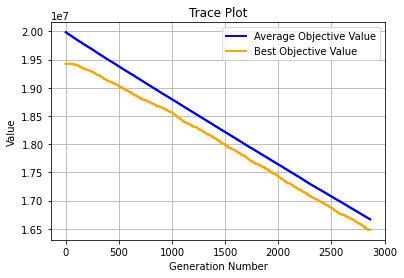

Execution time: 167.42256832122803 s
Evaluation number: 286500
The best objective value is: 16481166.32
The best variables are: 


1	1	0	0	0	0	0	1	1	0	0	0	0	1	0	1	1	0	0	0	0	1	0	0	1	0	0	0	0	0	1	1	0	0	1	0	0	0	0	1	0	0	0	0	0	1	0	0	0	1	0	1	0	0	0	1	0	1	0	1	1	0	1	1	0	0	0	1	1	0	0	0	1	0	0	1	1	1	0	0	1	0	0	1	0	1	1	1	0	0	0	0	0	0	0	1	0	1	0	0	0	0	1	0	0	0	0	0	0	1	1	1	1	1	0	0	0	0	0	1	0	0	0	1	1	0	1	0	1	0	1	0	1	1	0	0	0	1	1	0	0	0	1	1	0	0	1	1	1	1	0	1	1	0	0	0	0	1	1	1	0	1	1	0	1	1	1	1	1	0	1	1	1	0	0	1	1	1	0	0	0	1	0	0	0	0	0	0	0	0	0	1	1	0	1	1	1	1	0	0	0	1	0	1	0	0	0	0	0	1	0	1	1	0	0	1	0	1	0	0	0	0	1	0	0	1	0	0	0	1	1	0	0	0	0	1	0	1	0	0	1	0	0	1	1	0	0	0	1	0	0	0	1	0	0	0	1	0	1	0	0	1	1	0	0	0	1	0	0	0	1	1	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	1	0	0	0	1	0	1	0	0	0	0	0	0	1	0	0	0	0	0	1	0	1	0	1	0	0	1	1	0	1	1	0	1	0	0	1	0	0	0	1	1	0	0	1	1	1	1	0	0	0	0	0	0	1	0	0	0	0	1	1	0	0	1	0	1	0	1	1	1	0	1	0	0	1	0	1	1	0	1	0	1	1	1	0	1	0	0	1	0	1	0	1	1	0	1	0	1	1	0	1	1	0	0	1	0	0	0	0	1	0	0	0	1	1	0	1	1	0	0	1	0	1	1	1	0	0	1	1	0	0	0	0	0	0	1	0	1	0	1	0	0	0	1	0	1	0	0	0	1	0	0	0	0	0	1	0	0	1	0	0	0	0	0	1	1	1	0	0	0	1	1	0	0	0	0	0	1	0	0	1	0	1	1	0	1	1	1	0	0	1	0	0	1	0	0	0	0	0	1	0	0	0	0	0	1	0	0	0	0	0	1	0	0	

	1	1	1	0	0	1	0	0	0	0	1	1	1	0	0	1	0	1	1	0	0	1	0	1	0	0	0	1	0	0	1	1	0	0	1	0	0	0	0	1	0	1	0	1	1	1	0	0	1	0	0	1	0	0	1	0	0	1	1	0	0	0	1	1	1	1	1	0	1	0	0	1	0	1	1	0	1	0	1	0	0	0	0	0	1	1	0	0	0	0	1	1	1	1	0	0	0	0	1	0	1	1	1	0	1	0	0	0	0	0	1	1	1	1	0	0	0	1	0	0	0	1	0	1	1	0	1	1	0	1	0	0	0	1	0	1	0	1	0	1	1	0	1	0	0	1	0	1	1	0	1	1	0	0	1	1	1	0	1	1	0	1	0	0	1	0	0	1	0	1	0	0	1	0	1	1	0	0	1	1	0	0	1	1	0	0	1	0	1	0	1	0	0	0	0	1	0	1	1	0	0	0	1	0	0	0	1	0	0	0	0	1	1	0	1	0	1	0	0	1	1	0	1	0	0	1	1	1	1	0	0	1	1	0	0	0	1	1	0	0	0	1	0	0	0	0	0	1	0	1	0	0	0	1	1	0	1	0	1	0	0	1	1	1	0	1	1	0	0	0	0	0	0	0	0	0	0	1	1	1	0	0	0	1	0	1	0	0	0	1	1	1	0	0	0	0	0	0	1	1	1	0	0	1	1	0	1	1	1	0	0	0	1	0	1	1	1	1	0	0	0	1	1	1	1	0	1	0	0	0	0	0	1	1	1	1	1	1	1	1	1	1	0	0	1	0	1	1	1	0	1	1	1	0	1	1	1	1	0	1	0	1	1	1	0	1	0	1	0	1	0	0	0	0	0	0	0	0	1	1	0	1	1	0	0	1	0	0	0	1	1	1	0	1	1	0	0	1	0	1	0	1	0	1	1	0	1	0	1	0	0	1	1	0	1	0	1	1	1	0	0	1	1	0	0	0	0	1	0	1	1	1	0	1	0	0	0	0	1	0	0	1	0	0	0	0	0	1	0	1	1	0	1	0	0	1	1	1	1	0	1	1	0	0	0	1	0	0	0	0	0	0	0	1	0	1	0	0	1	0	0	1	0	0	0	0	1	1	1	1	1	0	1	0	0	0	0	1	0	0

In [33]:
# 1000, 1e-6, 100
selectedPackage = DEMO()

`NIND` barely has any influence on the final result, but will slow down the process. -- what about reduce to 100

`maxTrappedCount` has a big influence on the final result. U should try to increase maxTrappedCount to gain better performance.

#### Output

1000 gen = 13 minutes
No early stop if no feasible result is found.


In [53]:
print('Time Consumption: ', np.round(selectedPackage['executeTime'], decimals=2), 's')
print(selectedPackage['stopMsg'])

if selectedPackage['success']:
    print('Algorithm Succeeded!')
    print('===================================================================================================')
    print('Optimal Target Value: ', np.round(selectedPackage['ObjV'].item(), decimals=2))
    print('Constraint Violation: ', np.round(selectedPackage['CV'][0], decimals=2))
    if debug:
        # TODO: doing
        print('===================================================================================================')
        Vars = selectedPackage['Vars'][0]
        print('NBV of standard equip:', np.round((Vars * product @ nbv) / (Vars @ nbv), decimals=2)[0])
        print('Avg age of Manufacturing:', np.round((Vars @ mfrAge) / Vars.sum(), decimals=2)[0])
        print('Avg unexpired term under leases:', np.round((Vars * lesseStatus @ expYear) / (Vars * lesseStatus).sum(), decimals=2)[0])
        print('Top 1 NBV:', np.round((Vars * top1 @ nbv) / (Vars @ nbv), decimals=2)[0])
        print('Top 3 NBV:', np.round((Vars * top3 @ nbv) / (Vars @ nbv), decimals=2)[0])
        
else:
    print('No Feasible Results...')

Time Consumption:  318.33 s
The algotirhm stepped because it exceeded the trapped count limit.
Algorithm Succeeded!
Optimal Target Value:  19458029.26
Constraint Violation:  [-0.2  -3.44 -1.65 -0.  ]
NBV of standard equip: 1.0
Avg age of Manufacturing: 3.56
Avg unexpired term under leases: 6.65
Top 1 NBV: 0.5
Top 3 NBV: 0.98


In [54]:
# print final result
print('Selected Package:')
print('===================================================================================================')
print(len(selectedPackage['Vars'].nonzero()[1]), 'containers selected.')
print(selectedPackage['Vars'].nonzero()[1]) # index begins from 0
print('===================================================================================================')
print(selectedPackage['Vars'][0].tolist())

Selected Package:
4943 containers selected.
[   0    3    4 ... 9992 9996 9999]
[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0